***K-means preprocessing:*** l'obiettivo è estrarre i colori dall'immagine e normalizzare per i centroidi dei cluster degli stessi

import librerie (dò per scontato l'import delle altre librerie)

In [ ]:
# colab access + import libraries
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import numpy as np
import plotly.express as px
import cv2

from matplotlib import pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imsave

from skimage.transform import resize
from skimage import img_as_ubyte


Mounted at /content/drive


In [ ]:
import os
import cv2
from sklearn.cluster import KMeans
import random

!pip install imagecodecs
import imagecodecs

from heapq import nsmallest #mi dice quanti minimi e quali ci sono in una matrice

     |████████████████████████████████| 31.0 MB 55.1 MB/s 


In [ ]:
# Caricamento dataset in formato .rar da Google Drive a Colab
!pip install unrar
!unrar x "/content/drive/MyDrive/eim/cytology/train.rar"     # unraring training set
!unrar x "/content/drive/MyDrive/eim/cytology/validation.rar"   # unraring validation set
!unrar x "/content/drive/MyDrive/eim/cytology/test.rar"         # unraring test set


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/eim/cytology/train.rar

Creating    train                                                     OK
Creating    train/images                                              OK
Extracting  train/images/102.tif                                           0%  OK 
Extracting  train/images/104.tif                                           0%  1%  OK 
Extracting  train/images/106.tif                                           1%  OK 
Extracting  train/images/108.tif                                           1%  2%  OK 
Extracting  train/images/109.tif                                           2%  OK 
Extracting  train/images/111.tif                                           2%  3%  OK 
Extracting  train/images/112.tif                                           3%  OK 
Extracting  train/images/114.tif                      

peth + apertura file di prova random

there are 300 images in the training set
random image: 412.tif)
mask shape: (1920, 2560, 2)


Text(0.5, 1.0, 'mask')

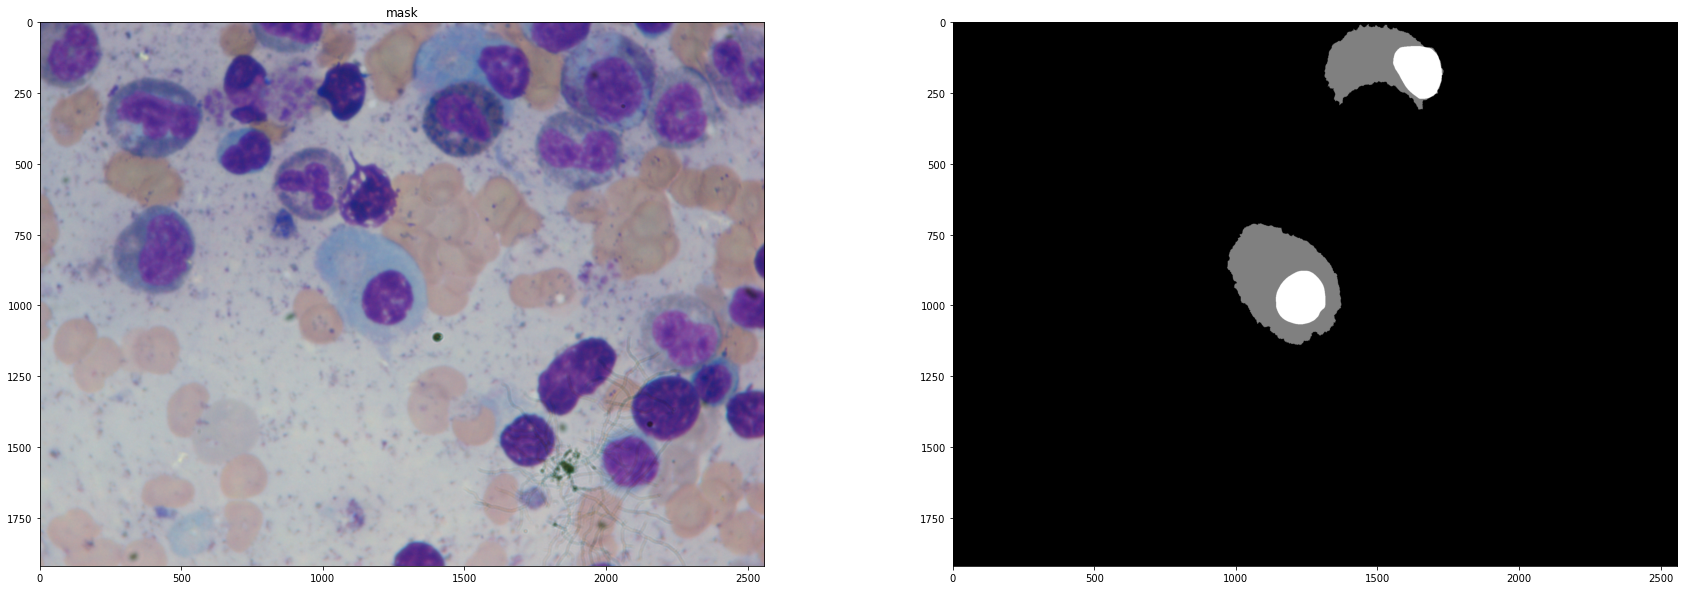

In [ ]:
# Path
tr_IMGS_path = os.path.join('train','images')
tr_MANU_path = os.path.join('train','manual')

# Extracting list of images
tr_images = os.listdir(tr_IMGS_path)
print(f"there are {len(tr_images)} images in the training set")

#estrazione causale immagine
rand_index=np.random.choice(len(tr_images))
print(f"random image: {tr_images[rand_index]})")

I = imread(os.path.join(tr_IMGS_path, tr_images[rand_index]))
mask = imagecodecs.imread(os.path.join(tr_MANU_path, tr_images[rand_index]))
print(f"mask shape: {mask.shape}")
if len(mask.shape)>2:                                 # if there is more than 1 MM cell in the current image
    mask = np.sum(mask,2,np.uint8)                    # merge the N layers segmentation in a unique greyscale image

# image + mask visualization
fig=plt.figure(figsize=(30,10))
ax1=plt.subplot(1,2,1)
ax1.imshow(I)
ax1.set_title('original image')

ax2=plt.subplot(1,2,2)
ax2.imshow(mask, cmap=plt.cm.gray)
ax1.set_title('mask')

apertura con cv2

(4915200, 3)

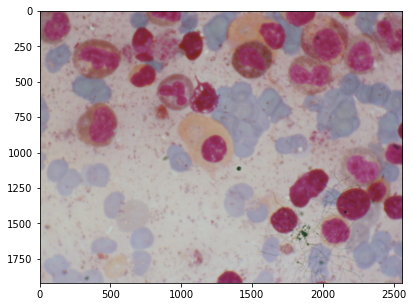

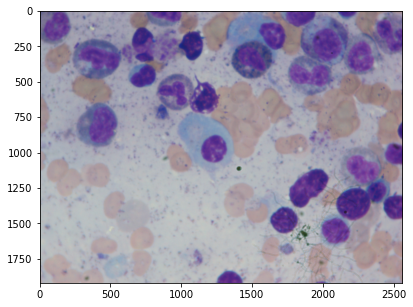

In [ ]:
img=cv2.imread(os.path.join(tr_IMGS_path, tr_images[rand_index]))
fig1 = plt.figure(figsize=(15,5))
plt.imshow(img)

img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
fig1 = plt.figure(figsize=(15,5))
plt.imshow(img)

img_re=img.reshape((img.shape[1]*img.shape[0],3))
img_re.shape

utilizzo il metodo di Elbow: per prendere il numero di cluster rilevanti

In [ ]:
#Elbow method
md=[]
for i in range(1,6):
  kmeans=KMeans(n_clusters=i)
  kmeans.fit(img_re)
  o=kmeans.inertia_
  md.append(o)
print(md)

plt.plot(list(np.arange(1,6)),md)
plt.show()

In [ ]:
md1=[]

for j,i in enumerate(md):
  if i>md[2] -0.10*md[2]:  # per prendere i centroidi rilevanti
    md1.append(i)

print(f"md1:{md1}")

In [ ]:
kmeans=KMeans(n_clusters=len(md1))
s=kmeans.fit(img_re)
labels=kmeans.labels_
centroid=kmeans.cluster_centers_
labels=list(labels)
percent=[]
for i in range(len(centroid)):
  j=labels.count(i)
  j=j/(len(labels))
  percent.append(j)

# Visualizzare immagine + pie
fig1 = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(img)
ax1.set_title('img')

ax2 = plt.subplot(1, 2, 2)
ax2.pie(percent,colors=np.array(centroid/255),labels=np.arange(len(centroid)))
ax2.set_title('pie')

In [ ]:
centroids=centroid/255
n=centroids.shape[0]*centroids.shape[1]
par_min=np.min(np.min(centroids))
par_max=np.max(np.max(centroids))

imgg=img/255

normalized= (imgg - par_min)/(par_max-par_min)

fig1 = plt.figure(figsize=(30,10))
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(img)
ax1.set_title('img')

ax1 = plt.subplot(1, 2, 2)
ax1.imshow(normalized)
ax1.set_title('norm')

pre-processing di tutte le immagini e salvataggio in un file zip

In [ ]:
#path_to_save=os.path.join("/content/drive/MyDrive/eim/cytology","preprocessed","images")
#if not os.path.exists(path_to_save):
#  os.mkdir(path_to_save)

this_path = os.getcwd()
this_path = this_path+'/preprocessed'
if not os.path.exists(this_path):
  os.mkdir(this_path)

In [ ]:
this_path

'/content/preprocessed'

In [ ]:
len(tr_images)

300

In [ ]:
for image in tr_images:
  img=cv2.imread(os.path.join(tr_IMGS_path, image))
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img_re=img.reshape((img.shape[1]*img.shape[0],3))

  #Elbow method
  md=[]
  for i in range(1,6):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(img_re)
    o=kmeans.inertia_
    md.append(o)

  md1=[]
  for j,i in enumerate(md):
     if i>md[2] -0.10*md[2]:  # per prendere i centroidi rilevanti (solitamente il ginocchio è dopo il 2°-3° valore)
        md1.append(i)

  #voglio che ci siano almeno 3 cluster: nucleo, citoplasma, background
  if len(md1)<3:
    n_cluster=3
  elif len(md1)>=3:
    n_cluster=len(md1)

  kmeans=KMeans(n_clusters=n_cluster)
  s=kmeans.fit(img_re)
  labels=kmeans.labels_
  centroid=kmeans.cluster_centers_
  labels=list(labels)
  percent=[]
  for i in range(len(centroid)):
     j=labels.count(i)
     j=j/(len(labels))
     percent.append(j)

  centroids=centroid/255
  n=centroids.shape[0]*centroids.shape[1]
  par_min=np.min(np.min(centroids))
  par_max=np.max(np.max(centroids))

  imgg=img/255

  normalized= (imgg - par_min)/(par_max-par_min)

  imsave(os.path.join(this_path,image),normalized)  # predicted heatmap saving

In [ ]:
#copio da this path a path to save solo la cartella compressa

!apt-get install rar
!rar a "preprocessed" "/content/drive/MyDrive/eim/cytology/preprocessed"